In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import linear_kernel


In [3]:
df = pd.read_csv('Data/netflix_cleaned.csv')
df


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,No Cast,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021,September
1,s2,TV Show,Blood & Water,No Director,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021,September
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Country Unavailable,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021,September
3,s4,TV Show,Jailbirds New Orleans,No Director,No Cast,Country Unavailable,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021,September
4,s5,TV Show,Kota Factory,No Director,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021,September
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8788,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,2019-11-20,2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a...",2019,November
8789,s8804,TV Show,Zombie Dumb,No Director,No Cast,Country Unavailable,2019-07-01,2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g...",2019,July
8790,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,2019-11-01,2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...,2019,November
8791,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,2020-01-11,2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...",2020,January


In [11]:
df.dropna(subset=['description','rating'], inplace=True)

/var/folders/yp/kssgm6y57msb36z47dpcly2m0000gn/T/ipykernel_25349/1352352368.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['description','rating'], inplace=True)


In [6]:
def group_ratings(rating):
    if rating in ['TV-MA', 'R', 'NC-17']:
        return 'Adult'
    elif rating in ['TV-14', 'PG-13']:
        return 'Teen'
    elif rating in ['TV-PG', 'PG']:
        return 'Family'
    elif rating in ['TV-Y', 'TV-Y7', 'G']:
        return 'Kids'
    else:
        return 'Unknown'

df['target_audience'] = df['rating'].apply(group_ratings)
df = df[df['target_audience'] != 'Unknown'] 

print(df['target_audience'].value_counts())

target_audience
Adult     4007
Teen      2647
Family    1148
Kids       680
Name: count, dtype: int64


In [7]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X = tfidf.fit_transform(df['description'])
y = df['target_audience']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Adult       0.55      0.79      0.65       799
      Family       0.36      0.08      0.13       236
        Kids       0.64      0.49      0.56       137
        Teen       0.43      0.33      0.37       525

    accuracy                           0.52      1697
   macro avg       0.50      0.42      0.43      1697
weighted avg       0.49      0.52      0.48      1697



In [8]:
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

In [9]:
num_clusters = 10
kmean = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmean.fit_predict(X)

svd = TruncatedSVD(n_components=2, random_state=42)
X_pca = svd.fit_transform(X)

/var/folders/yp/kssgm6y57msb36z47dpcly2m0000gn/T/ipykernel_25349/1557542078.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmean.fit_predict(X)


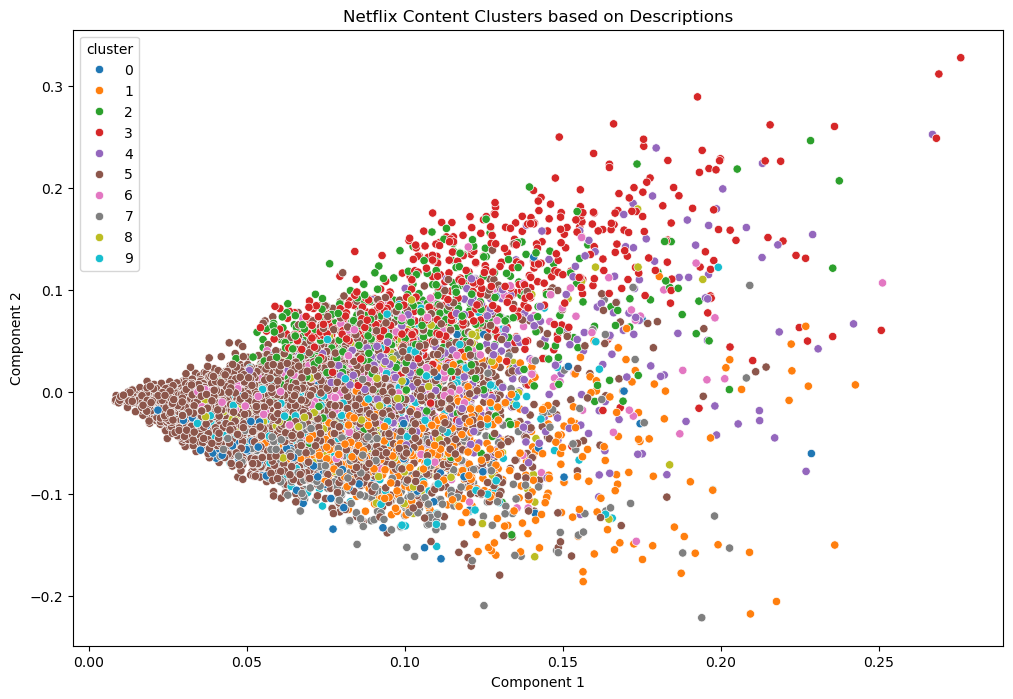

In [14]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], palette='tab10', legend='full')
plt.title('Netflix Content Clusters based on Descriptions')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [15]:
for i in range(num_clusters):
    print(f"\nCluster {i} Examples:")
    print(df[df['cluster'] == i]['title'].head(5).tolist())


Cluster 0 Examples:
['Schumacher', 'If I Leave Here Tomorrow: A Film About Lynyrd Skynyrd', 'Do the Right Thing', 'Korean Cold Noodle Rhapsody', 'Aftermath']

Cluster 1 Examples:
['Jailbirds New Orleans', 'Confessions of an Invisible Girl', 'Intrusion', 'Resurrection: Ertugrul', 'InuYasha the Movie 2: The Castle Beyond the Looking Glass']

Cluster 2 Examples:
['The Starling', 'Jeans', 'Naruto Shippuden: The Movie: The Lost Tower', 'Letters to Juliet', 'Kyaa Kool Hain Hum 3']

Cluster 3 Examples:
['Je Suis Karl', 'Birth of the Dragon', 'Jaws 3', 'Safe House', 'InuYasha the Movie 4: Fire on the Mystic Island']

Cluster 4 Examples:
['Love on the Spectrum', 'Minsara Kanavu', 'Ankahi Kahaniya', 'The Smart Money Woman', 'JJ+E']

Cluster 5 Examples:
['Dick Johnson Is Dead', 'Kota Factory', 'The Great British Baking Show', 'Vendetta: Truth, Lies and The Mafia', 'Bangkok Breaking']

Cluster 6 Examples:
['Blood & Water', 'Ganglands', 'Midnight Mass', 'Crime Stories: India Detectives', 'Falsa id

In [17]:
cosine_sim = linear_kernel(X, X)

incices = pd.Series(df.index, index=df['title']).drop_duplicates()

def get_recommendations(title, cosine_sim=cosine_sim):
    if title not in incices:
        return "Title not found in the dataset."
    
    idx = incices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return df['title'].iloc[movie_indices]

print(get_recommendations("Stranger Things"))
print(get_recommendations("The Irishman"))

5347                  Bountiful Blessings
7445                                 Milk
3555                     Falling Inn Love
7331                Losing Sight of Shore
2220                 Ip Man 4: The Finale
4234    Gina Yashere: Laughing to America
8556                      Theater of Life
1781                   Somebody Feed Phil
3770                    Tales of the City
8788                               Zodiac
Name: title, dtype: object
4356                        Love and Fortune
4743                   A Very Secret Service
4933                                     AMO
331                            Darwin’s Game
3339       Love, Chunibyo & Other Delusions!
8006                         Silicon Cowboys
3870    Code Geass: Lelouch of the Rebellion
457                         Lift Like a Girl
4741                                Switched
3826                               Revisions
Name: title, dtype: object
